# Assignment description

### Importing modules

In [2]:
import os 
from tqdm import tqdm
#from google.colab import drive
import shutil 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot  as plt
from pathlib import Path
import imagesize
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import pandas as pd
import zipfile 
import statistics 
import seaborn as sns
from sklearn.model_selection import train_test_split


## Download the dataset

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir dataset
!cp "gdrive/My Drive/DLL_project/dataset/Adaptiope.zip" dataset/
!ls dataset

Adaptiope.zip


In [ ]:
!unzip dataset/Adaptiope.zip

Streaming output truncated to the last 5000 lines.
  inflating: Adaptiope/synthetic/purse/purse_1_19.png  
  inflating: Adaptiope/synthetic/purse/purse_2_16.png  
  inflating: Adaptiope/synthetic/purse/purse_4_16.png  
  inflating: Adaptiope/synthetic/purse/purse_3_03.png  
  inflating: Adaptiope/synthetic/purse/purse_3_16.png  
  inflating: Adaptiope/synthetic/purse/purse_1_17.png  
  inflating: Adaptiope/synthetic/purse/purse_2_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_08.png  
  inflating: Adaptiope/synthetic/purse/purse_2_07.png  
  inflating: Adaptiope/synthetic/purse/purse_2_17.png  
  inflating: Adaptiope/synthetic/purse/purse_3_00.png  
  inflating: Adaptiope/synthetic/purse/purse_1_09.png  
  inflating: Adaptiope/synthetic/purse/purse_4_18.png  
  inflating: Adaptiope/synthetic/purse/purse_3_05.png  
  inflating: Adaptiope/synthetic/purse/purse_3_01.png  
  inflating: Adaptiope/synthetic/purse/purse_4_08.png  
  inflating: Adaptiope/synthetic/purse/purse_4_09.png

In [ ]:
! rm -rf adaptiope_small

In [ ]:
! mkdir adaptiope_small

The Adaptiope dataset should be reduced following the instructions. Therefore, only $20$ classes and two domains (i.e., _product images_ and _real life_) will be retained. 

In [3]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

domains = ["product_images", "real_life"]

In [3]:
with zipfile.ZipFile("data/Adaptiope.zip", 'r') as zip_f:
    namelist = zip_f.namelist() 
    images = [x for x in namelist if x.endswith(".jpg")]
    filter = [f"Adaptiope/{y}/{x}/" for y in domains for x in classes]
    cl_images = [x for x in images if x.startswith(tuple(filter))]
    zip_f.extractall(path = "data/", members= cl_images)

## Exploratory Data Analysis (EDA)


A basic Exploratory Data Analysis has been performed in order to understand the structure of the dataset and its characteristics. Therefore, the metadata of each image was extracted and saved into a dictionary (**metadata_img**). 

In [4]:

metadata_img = {}
root = "data/Adaptiope"

for domain in domains:
  subclass = os.listdir(f"{root}/{domain}")
  for cls_name in classes:
    imgs = [img.name for img in Path(f"{root}/{domain}/{cls_name}/").iterdir() if img.suffix == ".jpg"]
    for img in imgs: 
      metadata_img[str(img + domain)] = imagesize.get(f"{root}/{domain}/{cls_name}/"+img)



Secondly, some statistics have been performed on the dimensions in order to find out their average and standard deviation across the dataset. The results are reported below. 

In [5]:
img_df = pd.DataFrame.from_dict([metadata_img]).T.reset_index().set_axis(['file_name', 'size'], axis='columns', inplace=False)
img_df[["width", "height"]] = pd.DataFrame(img_df["size"].tolist(), index=img_df.index)

def find_domain(x):
    """
    Split the element name at the ".jpg" level and return its domain. 
    Args:
        x (str): name of the image's file, formatted as follow: file_name + .jpg + domain name

    Returns:
        x (str): name of the domain 
    """
    x = x[1:].split('.jpg')[-1]
    return x

img_df["domain"] = pd.DataFrame(img_df["file_name"].apply(find_domain))

avg_width = round(img_df["width"].sum() / len(img_df))
avg_height = round(img_df["height"].sum() / len(img_df))
sd_width = round(statistics.stdev(img_df["width"]), 2)
sd_height = round(statistics.stdev(img_df["height"]), 2)


print(f'Total images in reduced Adaptiope dataset: {len(img_df)}')

#print(f'Average height in Adaptiope dataset: {avg_height}')
#print(f'Std height in Adaptiope dataset: {sd_height}')

#print(f'Average width in Adaptiope dataset: {avg_width}')
#print(f'Std width in Adaptiope dataset: {sd_width}')

#print("Width:", "from", min(img_df["width"]), "to", max(img_df["width"]))
#print("Height", "from", min(img_df["height"]), "to", max(img_df["height"]))

Total images in reduced Adaptiope dataset: 4000



| Dimension| Average | Standard deviation | Minimum | Maximum |
|  :----: | :-----------: |:----------: |  :----: |  :----: | 
| Height | 1122 | 415.62| 75 | 2560|
| Width | 1160 | 415.42| 120| 2870|


Considering the magnitude of the standard deviations, further insights could be brought by the underlying distributions of _height_ and _width_. 

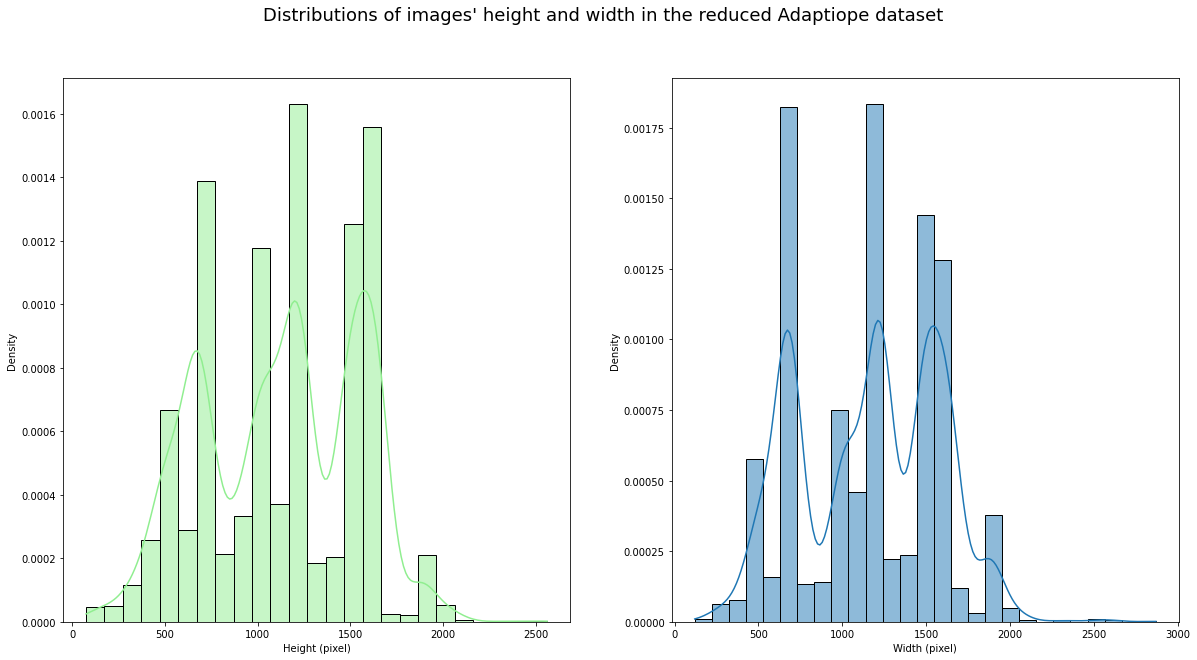

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
fig.suptitle("Distributions of images' height and width in the reduced Adaptiope dataset", fontsize=18)

sns.histplot(data=img_df["height"],
             kde=True, 
             ax = ax1, 
             stat = "density", 
             color="lightgreen"
             )

sns.histplot(data=img_df["width"],
             kde=True,
             ax = ax2, 
             stat = "density"
             )
ax1.set(xlabel='Height (pixel)', ylabel='Density')
ax2.set(xlabel='Width (pixel)', ylabel='Density')
plt.show()

From the histograms above, three main considerations follow: 
* the extreme points of the two distributions are quite broad, as they range from minima below 100 (pixel) and maxima around 2500 (pixel)

* three distinct and symmetric peaks are visible, corresponding to 700, 1200 and 1500 pixels

* the peaks' simmetry might suggest a high presence of squared images. 

To check whether the last consideration is correct, the code below is run. It aims to find out the percentage of images having an (almost) squared shape. Moreover, a threshold of $t = 1e^{-5}$ is introduced to detect pictures whose dimensions are almost similar, namely slightly rectangular shapes. 

In [14]:
thre = 1e-5 # threshold to check whether images are squared or almost squared
cond = np.logical_and(img_df['height'] - thre < img_df['width'], img_df['width'] < img_df['height'] + thre)
sq_df = img_df[cond]
print('Squared images in the dataset: ' + str(round(len(sq_df.index)/len(img_df.index), 2)*100) + " %")

Squared images in the dataset: 32.0 %


Even though a threshold is posed, only $\frac{1}{3}$ of the images are (almost) squared. This result should be taken into account while resizing and cropping the images, as the dimensions might be highly affected with a consistent lack of information. 

In [21]:
rect_df = img_df[~cond]
avg_size_diff = round(sum(abs(rect_df['width'] - rect_df['height'])) / len(rect_df.index), 2)
std_size_diff = round(statistics.stdev(abs(rect_df['width'] - rect_df['height'])), 2)
print(f'Size difference: {avg_size_diff} ± {std_size_diff}')

Size difference: 421.57 ± 258.17


## Data Transformation

In [9]:
def data_transformation(resize_dim = 256, crop_dim = 224, grayscale = True, crop_center = True):
    
    transform_lst = []
    transform_lst.append(T.Resize((resize_dim)))                                                          
    
    if grayscale:
        transform_lst.append(T.Grayscale(num_output_channels=3))                        
    
    if crop_center:
        transform_lst.append(T.CenterCrop((crop_dim)))
    else:
        transform_lst.append(T.RandomCrop((crop_dim)))
    
    transform_lst.append(T.RandomHorizontalFlip(p=0.5))                                  
    transform_lst.append(T.ToTensor())                                             
        
    return T.Compose(transform_lst)  

# transforms.RandomResizedCrop(224) interessante ma con un approccio diverso https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html 

In [11]:
def normalization(dataset):
    ds_length = len(dataset)
    for i in tqdm(range(ds_length)):
        r_mean, g_mean, b_mean = torch.mean(dataset[i][0], dim = [1,2])
        r_std, g_std, b_std = torch.std(dataset[i][0], dim = [1,2])
        T.functional.normalize(
            tensor = dataset[i][0], 
            mean = [r_mean, g_mean, b_mean],
            std = [r_std, g_std, b_std],
            inplace=True
            )
    return dataset

In [12]:
source = "product_images"
target = "real_life"
resize_dim = 256
crop_dim = 224
grayscale = False
crop_center = True 


source_ds = torchvision.datasets.ImageFolder(
    root = f"data/Adaptiope/{source}",
    transform = data_transformation(resize_dim, crop_dim, grayscale, crop_center)
    )

target_ds = torchvision.datasets.ImageFolder(
    root = f"data/Adaptiope/{target}",
    transform = data_transformation(resize_dim, crop_dim, grayscale, crop_center)
    ) 

if not grayscale:
    normalization(source_ds)
    normalization(target_ds)
    

100%|██████████| 2000/2000 [02:46<00:00, 12.00it/s]


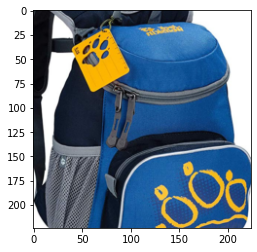

In [16]:
# Check whether the transformations work

inputs, classes = next(iter(source_ds))
plt.imshow(inputs.permute(1, 2, 0))
plt.show()



## Train/Test split 

The chosen split follows the assignment and divides each domain in 80/20. 

In [17]:
batch_size = 32
test_split = 0.2 

def get_data(dataset, test_split = test_split, batch_size = batch_size):
    
    train_indices, val_indices = train_test_split(
        list(range(len(dataset.targets))),
        test_size = test_split,
        stratify = dataset.targets, 
        random_state = 42
        )
    
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)

    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_data_loader, val_data_loader
    

In [18]:
source_train_loader, source_test_loader = get_data(source_ds)
target_train_loader, target_test_loader = get_data(target_ds)

# Feature extraction 


In [21]:
resnet18 = True

if resnet18: 
    model = torchvision.models.resnet18(pretrained=True)
else:
    model = torchvision.models.resnet50(pretrained=True)
    
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# Check the feature extractor works
x = torch.randn([1,3,224,224])
output = feature_extractor(x) 
print(output.shape)

torch.Size([1, 512, 1, 1])


## Domain Classifier SOURCE 

https://github.com/yrahul3910/symnet/tree/master/symnet/image 